## Task 1 State Vector Simulation of Quantum Circuits

For this task, you will implement a state vectorstatevector simulator for quantum circuits from scratch. The goal is to demystify how to simulate a quantum computer and to demonstrate your familiarity with quantum circuits.

In [1]:
# Import required Library
import time # for time benchmarking
import numpy as np # for calculation
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit # for testing and comparison
from qiskit_aer import AerSimulator


### 0. Tested Initial States and Circuits

In this project, the initial state of all circuits will be set to: \( |0\rangle \) for the single-qubit case, \( |00\rangle \) for two qubits, and so on, \( |00\ldots0\rangle \) for \( N \) qubits. The vector array representation for each case would then be \([1, 0]\) for a single qubit, \([1, 0, 0, 0]\) for two qubits, and so on for \( N \) qubits: \([1, 0, 0, \ldots, 0]\).

The tested circuits are dummy circuits that consist of X, H, and CNOT gates, with a constantly increasing number of qubits. The X and H gates are applied to all qubits from \( 0 \) to \( N-1 \), while the CNOT gate is only applied once, with the control and target qubits being the first and last qubits, respectively.

For testing purposes, the Qiskit visualization library will be used to show the results of simulations of these circuits for simple cases with 2 and 3 qubits.


- 2 qubits example:

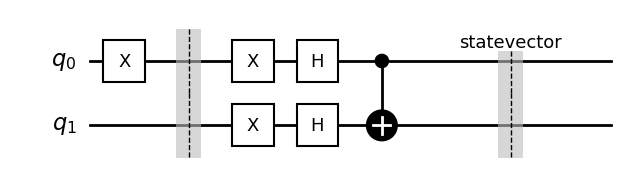

In [2]:
qc = QuantumCircuit(2)

qc.x(0)
qc.barrier()
qc.x([0,1])
qc.h([0,1])
qc.cx(0,1)

qc.save_statevector()

qc.draw(reverse_bits=False, style="bw")



In [3]:
result = AerSimulator().run(qc).result()
psi = result.get_statevector()
psi.draw(output='latex')

<IPython.core.display.Latex object>

- 3 qubits example:

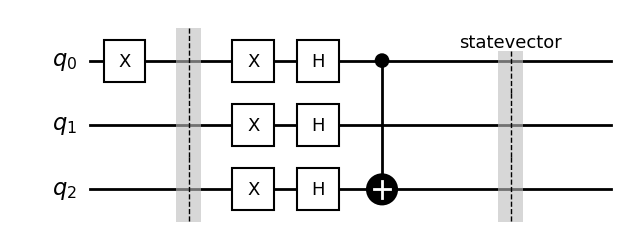

In [4]:
qc = QuantumCircuit(3)

qc.x(0)

qc.barrier()

qc.x([0,1,2])
qc.h([0,1,2])
qc.cx(0,2)

qc.save_statevector()

qc.draw(reverse_bits=False, style="bw")

In [5]:
result = AerSimulator().run(qc).result()
psi = result.get_statevector()
psi.draw(output='latex')

<IPython.core.display.Latex object>

### 1. Naive Simulation using Matrix Multiplication

#### 1.a Initialize Function

In [8]:
def n_kron_product(matrix, n):
    """
    calculate kron product of matrix n times. For example, used to expand the single-qubit quantum gate (H, X, ...) to all other qubits
    """

    result = matrix
    for i in range(n-1):
        result = np.kron(result, matrix)

    return result

def n_cnot_gate(n):
    """
    construct 2-qubit CNOT gate matrix representation. This code below allowed to customize the control and target qubit to create the corresponding circuits. In general, in this circuit example we will always use the control qubit in the first qubit (0) and the target qubit in the last (n-1)
    """

    dist = n - 2 # distance or the number of qubits between control and target qubit (in this case, always first and last qubit)

    sq_X = np.array([[0,1], [1,0]]) # single qubit X gate

    N = 2 ** (dist+2)
    N_half = int(N/2)

    I_half_N = np.identity(N_half)

    Zero_half_N = np.zeros((N_half, N_half))

    I_quarter_N = np.identity(int(N/4))
    right_bottom_matrix = np.kron(I_quarter_N, sq_X)
    
    # print("I_half_N", I_half_N)
    # print("Zero_half_N", Zero_half_N)
    # print("RB", right_bottom_matrix)

    CX = np.block([[I_half_N, Zero_half_N],
                [Zero_half_N, right_bottom_matrix]])

    # print(CX)
    # print(np.kron(I, CX))  
    return CX 

#### 1.b Initialize Simulator

In [9]:
# qubits = 15

# Define Single qubit state and gate
sq_ket_0 = np.array([1,0])
sq_ket_1 = np.array([0,1])

sq_I = np.array([[1,0], [0,1]])
sq_X = np.array([[0,1], [1,0]])
sq_H = 1/np.sqrt(2)*np.array([[1,1], [1,-1]])

dq_CNOT = np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,0,1],
                    [0,0,1,0],])



def quantum_simulator(qubits):

    start_time = time.time()
    # Define n qubits quantum gates
    n_sq_X = n_kron_product(sq_X, qubits)
    n_sq_H = n_kron_product(sq_H, qubits)
    n_cnot = n_cnot_gate(qubits)

    # Define n qubits statevectors
    n_statevector = n_kron_product(sq_ket_0, qubits)
    # print(n_statevector)

    result = n_cnot @ n_sq_H @ n_sq_X @ n_statevector
    end_time = time.time()
    runtime = end_time - start_time
    # print(result)

    return result, runtime

#### 1.c Test in 2 and 3 qubits

In [10]:
qubits_range = np.arange(2,4,1)
print("Test for simpler version in qubits 2 and 3")

results_range = []
runtime_range = []

for qubit in qubits_range:
    result, runtime = quantum_simulator(qubit)
    results_range.append(result)
    runtime_range.append(runtime)
    print("\nqubits:", qubit, ", runtime:", runtime, 'seconds')
    print("Statevector:", result)

Test for simpler version in qubits 2 and 3

qubits: 2 , runtime: 0.0008220672607421875 seconds
Statevector: [ 0.5 -0.5  0.5 -0.5]

qubits: 3 , runtime: 0.00026988983154296875 seconds
Statevector: [ 0.35355339 -0.35355339 -0.35355339  0.35355339  0.35355339 -0.35355339
 -0.35355339  0.35355339]


Both of the previous results are the same with the tested results obtained using Qiskit library

#### 1.d Simulations

In [11]:
qubits_range = np.arange(2,20,1)
print(qubits_range)

matrix_results_range = []
matrix_runtime_range = []

for qubit in qubits_range:
    result, runtime = quantum_simulator(qubit)
    matrix_results_range.append(result)
    matrix_runtime_range.append(runtime)
    print("qubits:", qubit, ", runtime:", runtime)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
qubits: 2 , runtime: 0.0011205673217773438
qubits: 3 , runtime: 0.0004222393035888672
qubits: 4 , runtime: 0.0007808208465576172
qubits: 5 , runtime: 0.0003037452697753906
qubits: 6 , runtime: 0.00045037269592285156
qubits: 7 , runtime: 0.008708000183105469
qubits: 8 , runtime: 0.03484296798706055
qubits: 9 , runtime: 0.03273773193359375
qubits: 10 , runtime: 0.09446549415588379
qubits: 11 , runtime: 0.4157431125640869
qubits: 12 , runtime: 2.1968576908111572
qubits: 13 , runtime: 16.599263429641724


: 

From the runtime above, we conclude that matrix multiplication simulators only able to simulate up to 13 qubits. Therefore, the next simulations will only to 13 qubits to obtain the data and plot the charts

In [11]:
qubits_range = np.arange(2,14,1)
print(qubits_range)

matrix_results_range = []
matrix_runtime_range = []

for qubit in qubits_range:
    result, runtime = quantum_simulator(qubit)
    matrix_results_range.append(result)
    matrix_runtime_range.append(runtime)
    print("qubits:", qubit, ", runtime:", runtime)

[ 2  3  4  5  6  7  8  9 10 11 12 13]
qubits: 2 , runtime: 0.0003211498260498047
qubits: 3 , runtime: 0.0007061958312988281
qubits: 4 , runtime: 0.0002658367156982422
qubits: 5 , runtime: 0.0007512569427490234
qubits: 6 , runtime: 0.0004432201385498047
qubits: 7 , runtime: 0.008176326751708984
qubits: 8 , runtime: 0.020938396453857422
qubits: 9 , runtime: 0.030638456344604492
qubits: 10 , runtime: 0.11023616790771484
qubits: 11 , runtime: 0.6443958282470703
qubits: 12 , runtime: 3.345116138458252
qubits: 13 , runtime: 24.227020502090454


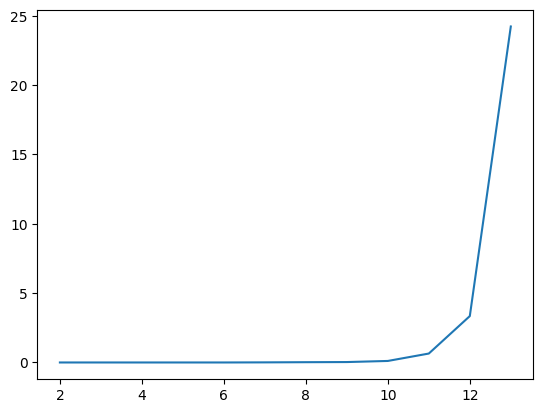

In [12]:
plt.plot(qubits_range, matrix_runtime_range)

### 2. Advanced Simulation using Tensor Multiplication

#### 2.a Initialize Functions

In [2]:
H_gate = 1/np.sqrt(2)*np.array([[1,1],
                    [1,-1]])

X_gate = np.array([[0,1],
                   [1,0]])

CNOT_gate = np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,0,1],
                    [0,0,1,0]]).reshape(2,2,2,2)

def apply_single_qubit_gate(state, gate, target_qubit):

    psi_updated = np.tensordot(gate, state, axes=(1,target_qubit))
    psi_updated = np.moveaxis(psi_updated, 0, target_qubit)

    return psi_updated

def apply_cnot_gate(state, target_qubit, control_qubit):

    psi_updated = np.tensordot(CNOT_gate, state, ((2,3), (control_qubit, target_qubit)))
    psi_updated = np.moveaxis(state, (0,1), (control_qubit, target_qubit))

    return psi_updated


#### 2.b Initialize Simulator

In [3]:
def quantum_simulator(N):
    
    start_time = time.time()

    psi = np.zeros((2,)*N)
    psi[(0,)*N] = 1 #initiate example state: |000...001> 
    
    for i in range(N): # apply the gate for each qubit
        psi = apply_single_qubit_gate(psi, X_gate, i)
        psi = apply_single_qubit_gate(psi, H_gate, i)
    
    psi = apply_cnot_gate(psi, N-1, 0)
    
    end_time = time.time()
    runtime = end_time - start_time

    result = psi
    
    return result, runtime

#### 2.c Test in 2 and 3 qubits

In [22]:
qubits_range = np.arange(2,4,1)
print("Test for simpler version in qubits 2 and 3")

results_range = []
runtime_range = []

for qubit in qubits_range:
    result, runtime = quantum_simulator(qubit)
    results_range.append(result)
    runtime_range.append(runtime)
    print("\nqubits:", qubit, ", runtime:", runtime, 'seconds')
    print("Statevector:", result.flatten())

Test for simpler version in qubits 2 and 3

qubits: 2 , runtime: 0.0007908344268798828 seconds
Statevector: [ 0.5 -0.5 -0.5  0.5]

qubits: 3 , runtime: 0.0006918907165527344 seconds
Statevector: [ 0.35355339 -0.35355339 -0.35355339  0.35355339 -0.35355339  0.35355339
  0.35355339 -0.35355339]


#### 2.d Simulations

In [25]:
tensor_qubits_range = np.arange(2,30,1)
print("Test for simpler version in qubits 2 and 3")

tensor_results_range = []
tensor_runtime_range = []

for qubit in tensor_qubits_range:
    result, runtime = quantum_simulator(qubit)
    tensor_results_range.append(result)
    tensor_runtime_range.append(runtime)
    print("qubits:", qubit, ", runtime:", runtime, 'seconds')
    # print("Statevector:", result.flatten())F

Test for simpler version in qubits 2 and 3
qubits: 2 , runtime: 0.0010607242584228516 seconds
qubits: 3 , runtime: 0.0004456043243408203 seconds
qubits: 4 , runtime: 0.0008835792541503906 seconds
qubits: 5 , runtime: 0.0011065006256103516 seconds
qubits: 6 , runtime: 0.00021982192993164062 seconds
qubits: 7 , runtime: 0.0002391338348388672 seconds
qubits: 8 , runtime: 0.000274658203125 seconds
qubits: 9 , runtime: 0.00036525726318359375 seconds
qubits: 10 , runtime: 0.0003781318664550781 seconds
qubits: 11 , runtime: 0.00044608116149902344 seconds
qubits: 12 , runtime: 0.0008356571197509766 seconds
qubits: 13 , runtime: 0.0008895397186279297 seconds
qubits: 14 , runtime: 0.0013322830200195312 seconds
qubits: 15 , runtime: 0.0027022361755371094 seconds
qubits: 16 , runtime: 0.005671501159667969 seconds
qubits: 17 , runtime: 0.017839431762695312 seconds
qubits: 18 , runtime: 0.174163818359375 seconds


qubits: 19 , runtime: 0.29311299324035645 seconds
qubits: 20 , runtime: 0.46660757064819336 seconds
qubits: 21 , runtime: 0.7794327735900879 seconds
qubits: 22 , runtime: 1.26377534866333 seconds
qubits: 23 , runtime: 2.3559141159057617 seconds
qubits: 24 , runtime: 4.319746732711792 seconds
qubits: 25 , runtime: 8.034213066101074 seconds
qubits: 26 , runtime: 16.070667505264282 seconds
qubits: 27 , runtime: 37.98771595954895 seconds


: 

From the results above, we conclude that the maximum number of qubits that can be simulated with tensor multiplication is higher than the matrix multiplication, which is up to 27 qubits. The runtime charts was shown below:

In [4]:
tensor_qubits_range = np.arange(2,28,1)
print("Test for simpler version in qubits 2 and 3")

tensor_results_range = []
tensor_runtime_range = []

for qubit in tensor_qubits_range:
    result, runtime = quantum_simulator(qubit)
    tensor_results_range.append(result)
    tensor_runtime_range.append(runtime)
    print("qubits:", qubit, ", runtime:", runtime, 'seconds')
    # print("Statevector:", result.flatten())F

Test for simpler version in qubits 2 and 3
qubits: 2 , runtime: 0.0004458427429199219 seconds
qubits: 3 , runtime: 0.00012731552124023438 seconds
qubits: 4 , runtime: 0.00012755393981933594 seconds
qubits: 5 , runtime: 0.0001556873321533203 seconds
qubits: 6 , runtime: 0.00017762184143066406 seconds
qubits: 7 , runtime: 0.00020170211791992188 seconds
qubits: 8 , runtime: 0.0002765655517578125 seconds
qubits: 9 , runtime: 0.0002741813659667969 seconds
qubits: 10 , runtime: 0.0003311634063720703 seconds
qubits: 11 , runtime: 0.0005033016204833984 seconds
qubits: 12 , runtime: 0.0007090568542480469 seconds
qubits: 13 , runtime: 0.0013835430145263672 seconds
qubits: 14 , runtime: 0.0016002655029296875 seconds
qubits: 15 , runtime: 0.0026302337646484375 seconds
qubits: 16 , runtime: 0.005429744720458984 seconds
qubits: 17 , runtime: 0.03134655952453613 seconds
qubits: 18 , runtime: 0.0807042121887207 seconds
qubits: 19 , runtime: 0.1698155403137207 seconds
qubits: 20 , runtime: 0.2868669033

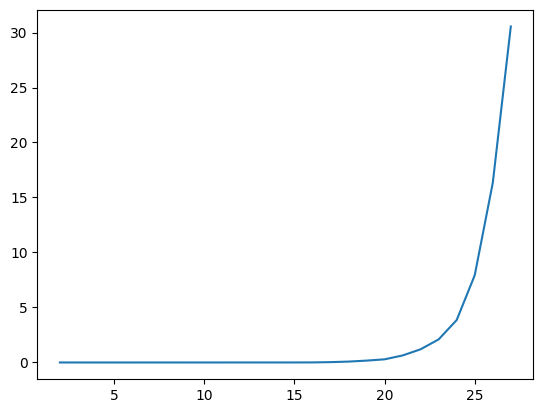

In [5]:
plt.plot(tensor_qubits_range, tensor_runtime_range)

### == Final Chart Comparison ==

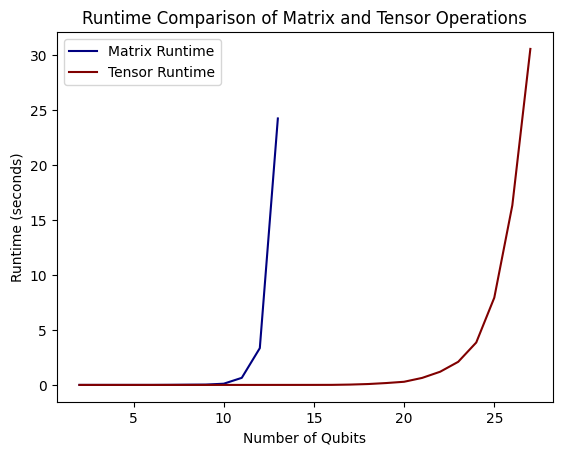

In [15]:
# Plotting
plt.plot(qubits_range, matrix_runtime_range, label='Matrix Runtime', color='navy')
plt.plot(tensor_qubits_range, tensor_runtime_range, label='Tensor Runtime', color='maroon')

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of Matrix and Tensor Operations')

# Display the plot
plt.show()


It is clear from the chart above that the tensor operations-based simulation can simulate more qubits than the matrix operations simulation. One of the reasons is that, in the matrix simulation, the operations are calculated directly or simultaneously for all circuits using the Kronecker product between operators on each qubit, which results in significantly larger matrices and hence limits the simulation capabilities.

### 3. Bonus Question

### 3.1 Sample From the Final States

### 3.2 Computing Exact Expectation Values